## Customer Segmentation Analysis: Unveiling Insights from Shopping Behavior

In today's competitive retail landscape, understanding customer behavior is paramount to crafting personalized experiences and driving business growth. This analysis focuses on segmenting customers based on their shopping patterns using data from various transactions made at different shopping malls. By leveraging advanced Machine Learning techniques, specifically **K-Means clustering**, we aim to identify distinct customer segments that reveal hidden trends in purchasing behavior.

Our dataset captures a wide range of customer interactions, including product categories, quantities purchased, payment methods, and demographic details such as age and gender. Through this analysis, we seek to uncover meaningful insights that can inform strategic decisions in marketing, product recommendations, and customer relationship management.

The segmentation process allows us to categorize customers into unique groups, each characterized by their spending habits, product preferences, and purchase frequency. By visualizing these segments, we will explore which customers are high-value, which exhibit a tendency toward specific product categories, and how demographic factors influence shopping choices.

This analysis not only provides a comprehensive understanding of the customer base but also sets the foundation for targeted marketing strategies, improved customer retention, and enhanced overall customer experience. Let’s embark on this journey of discovery and see how data-driven insights can transform business decisions.

OBS: In the texts, **TL** stands for **Turkish Lira**, which is the official currency of Turkey. It is used in the dataset to indicate the price of products in **Turkish Lira**.

## Data Loading and Preprocessing

In [17]:
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [18]:
# Load the dataset
df = pd.read_csv('customer_shopping_data.csv')

In [19]:
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [20]:
df.isnull().sum()

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


## Exploratory Data Analysis (EDA)

#### We’ll explore the dataset to understand the distribution of important features like age, gender, total quantity bought, and price.

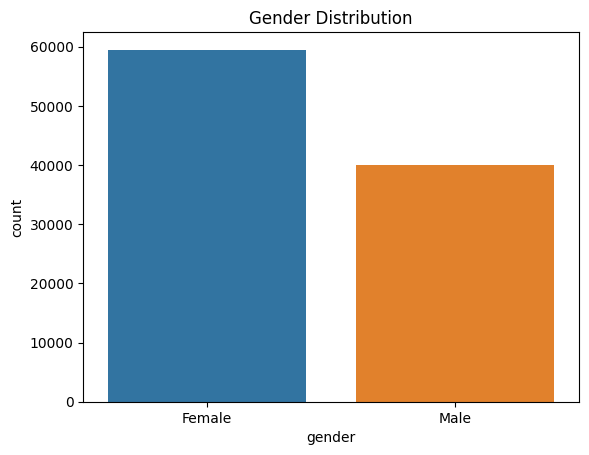

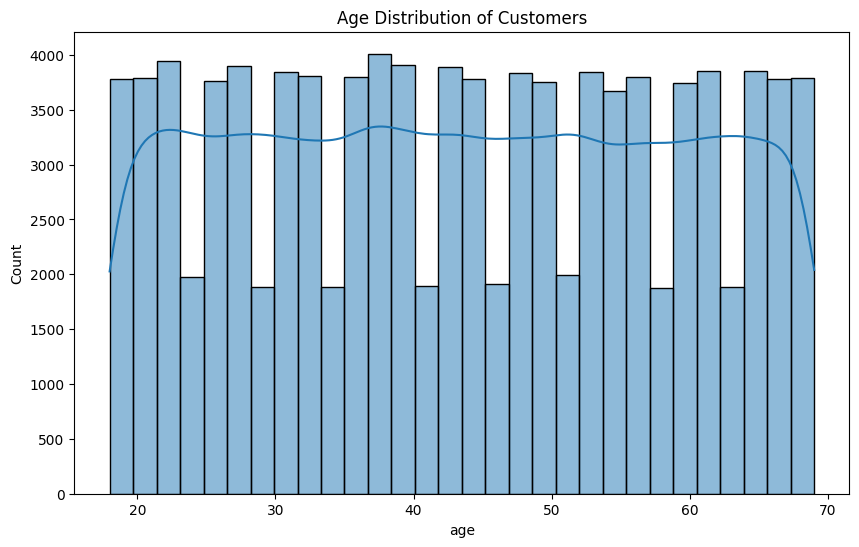

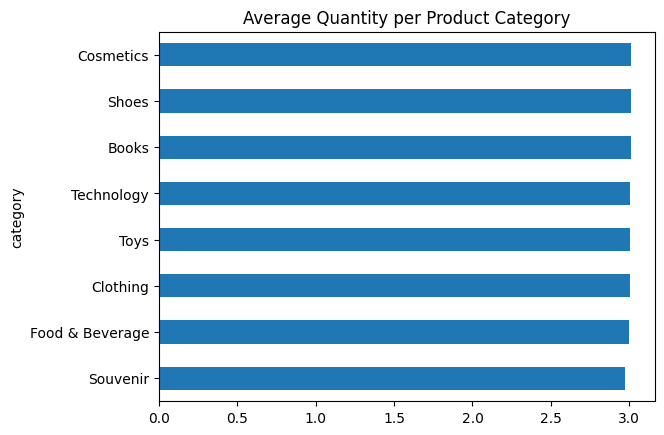

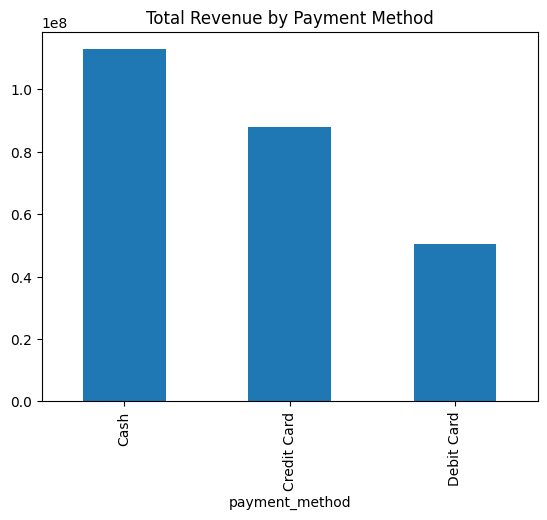

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of gender
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

# Distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution of Customers')
plt.show()

# Average quantity purchased per category
category_quantity = df.groupby('category')['quantity'].mean().sort_values()
category_quantity.plot(kind='barh', title='Average Quantity per Product Category')
plt.show()

# Total revenue per payment method
df['total_price'] = df['quantity'] * df['price']
payment_revenue = df.groupby('payment_method')['total_price'].sum()
payment_revenue.plot(kind='bar', title='Total Revenue by Payment Method')
plt.show()

## Feature Engineering

#### We will create some useful features for clustering, such as the total price per customer and the number of unique categories purchased.

In [23]:
# Creating new features
df['total_spent'] = df['quantity'] * df['price']

# Aggregating data at the customer level
customer_data = df.groupby('customer_id').agg({
    'total_spent': 'sum',
    'quantity': 'sum',
    'category': 'nunique',  # Number of unique product categories purchased
    'age': 'mean',
}).reset_index()

# Renaming for clarity
customer_data = customer_data.rename(columns={
    'category': 'num_categories',
    'quantity': 'total_quantity',
    'age': 'avg_age'
})

customer_data.head()

,customer_id,total_spent,total_quantity,num_categories,avg_age
0,C100004,7502.00,5,1,61.0
1,C100005,2400.68,2,1,34.0
2,C100006,322.56,3,1,44.0
3,C100012,130.75,5,1,25.0
4,C100019,35.84,1,1,21.0


## Clustering Model (K-Means)

#### We will apply K-Means clustering to segment the customers based on their shopping behavior.

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecting features for clustering
X = customer_data[['total_spent', 'total_quantity', 'num_categories', 'avg_age']]

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fitting K-Means model
kmeans = KMeans(n_clusters=4, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(X_scaled)

# Inspect the cluster assignments
print(customer_data['cluster'].value_counts())

2    33916
1    28767
0    24401
3    12373
Name: cluster, dtype: int64


These numbers represent the **distribution of customers across different clusters** after applying the K-Means clustering algorithm. Specifically:

- **Cluster 2** contains **33,916 customers**, which is the largest group.
- **Cluster 1** has **28,767 customers**.
- **Cluster 0** includes **24,401 customers**.
- **Cluster 3** is the smallest cluster, with **12,373 customers**.

Each cluster groups customers based on their shopping behavior, as determined by the selected features (e.g., total spending, total quantity, number of categories purchased). The clusters aim to identify similar patterns among customers, allowing for segmentation based on their purchasing profiles.

The **cluster numbers (0, 1, 2, 3)** are arbitrary labels assigned by the K-Means algorithm and do not imply any rank or order.

## Visualizing the Clusters

#### We’ll visualize the customer segments using a 2D projection to understand how they are grouped.

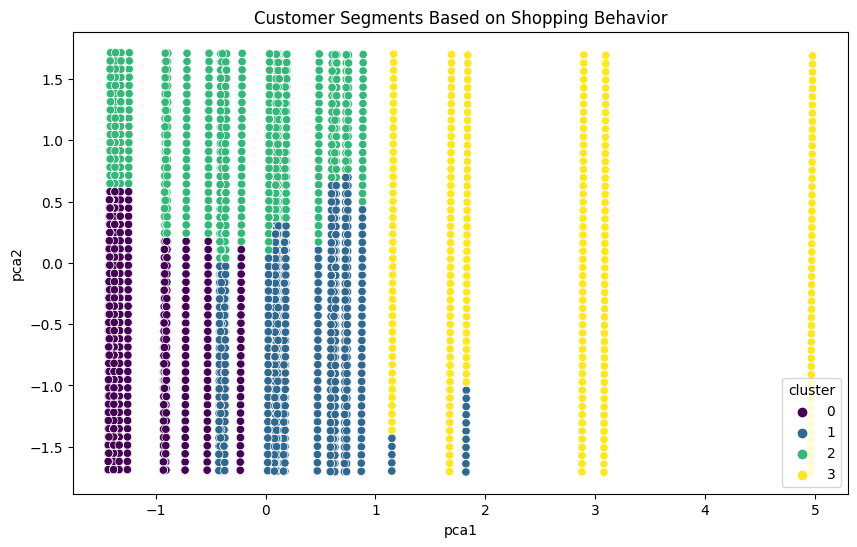

In [25]:
from sklearn.decomposition import PCA

# Reducing dimensions for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Adding PCA components to the DataFrame
customer_data['pca1'] = pca_components[:, 0]
customer_data['pca2'] = pca_components[:, 1]

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=customer_data, palette='viridis')
plt.title('Customer Segments Based on Shopping Behavior')
plt.show()

## Interpretation of Results

#### Finally, we interpret the clusters to understand the characteristics of each segment, such as high spenders, frequent buyers, or customers with diverse product purchases.

In [26]:
# Analyzing the clusters
cluster_summary = customer_data.groupby('cluster').agg({
    'total_spent': ['mean', 'sum'],
    'total_quantity': ['mean', 'sum'],
    'num_categories': ['mean'],
    'avg_age': ['mean']
})

print(cluster_summary)

          total_spent               total_quantity         num_categories  \
                 mean           sum           mean     sum           mean   
cluster                                                                     
0          545.046732  1.329969e+07       1.452359   35439            1.0   
1         1963.674603  5.648903e+07       3.951159  113663            1.0   
2         1170.492527  3.969842e+07       2.729921   92588            1.0   
3        11478.110166  1.420187e+08       4.608583   57022            1.0   

           avg_age  
              mean  
cluster             
0        33.598377  
1        32.472208  
2        58.783111  
3        46.187505  


### Cluster Interpretation:

1. **Cluster 0**: 
   - **Spending Behavior**: This group has the lowest average spending per customer, with a mean total spent of **545.05 TL**. Despite being the smallest spender on average, the cluster's total spending amounts to **13.3 million TL** across all customers. 
   - **Purchase Quantity**: Customers in this cluster buy relatively few items, with an average of **1.45 items per customer**. This suggests a pattern of sporadic, low-volume purchases.
   - **Categories Purchased**: Interestingly, the customers in this cluster typically stick to a single category, indicating specialized or specific product preferences.
   - **Demographics**: The average age of customers in this group is **33.6 years**, which suggests this cluster might represent younger, budget-conscious shoppers who make occasional low-cost purchases.

2. **Cluster 1**: 
   - **Spending Behavior**: With an average total spend of **1963.67 TL**, this cluster represents higher spenders compared to Cluster 0. The total spending for this group is substantial, reaching **56.5 million TL**.
   - **Purchase Quantity**: Customers here buy around **3.95 items on average**, indicating a greater engagement in purchasing activities compared to Cluster 0. 
   - **Categories Purchased**: Similar to Cluster 0, customers in this cluster typically stick to **one product category** despite purchasing a higher quantity of items, perhaps indicating repeat purchases of favored items.
   - **Demographics**: The average age is **32.5 years**, which is quite similar to Cluster 0, suggesting this cluster represents relatively young individuals, but with a higher purchasing power and engagement in shopping.

3. **Cluster 2**: 
   - **Spending Behavior**: This cluster represents middle-aged to senior customers with a considerably higher average spending of **1170.49 TL**. The total spending for this cluster is **39.7 million TL**.
   - **Purchase Quantity**: Customers here purchase an average of **2.73 items**, indicating moderate purchasing activity, similar to Cluster 1 but lower than Cluster 3.
   - **Categories Purchased**: Like other clusters, they stick to a single category, which could suggest loyalty to a specific product type or less exploratory shopping behavior.
   - **Demographics**: The standout feature of this cluster is the significantly older average age of **58.8 years**, suggesting this segment represents an older, wealthier group of shoppers with higher disposable income but specific preferences.

4. **Cluster 3**:
   - **Spending Behavior**: This is the **high-value cluster**, with an average total spend of **11,478.11 TL** per customer, by far the highest of all the groups. The total spending for this cluster is a remarkable **142 million TL**, showing that although smaller in number, these customers contribute significantly to revenue.
   - **Purchase Quantity**: Customers in this cluster buy an average of **4.61 items**, which is the highest across all clusters. This suggests they are highly engaged, purchasing both in volume and frequency.
   - **Categories Purchased**: Despite their high expenditure, they also tend to stick to **one product category**, which may indicate brand or category loyalty among high-spending individuals.
   - **Demographics**: The average age of **46.2 years** positions this cluster in the mid-to-late adulthood range, likely representing affluent individuals with established purchasing habits and a tendency to spend significantly on premium products.

---

### Summary:

- **Cluster 0** represents **younger, low-spending customers** with limited product variety, potentially offering opportunities for increased engagement through targeted promotions.
- **Cluster 1** consists of **young, higher-spending customers**, indicating they could be a growth segment with further engagement.
- **Cluster 2** captures **older customers with moderate spending**, possibly reflecting a more stable, loyal customer base.
- **Cluster 3** is the **premium segment**, consisting of high-value customers who spend significantly more and buy in greater quantities. Retaining this group and deepening their engagement is critical to the business's profitability.

This segmentation provides valuable insights for targeted marketing strategies, from loyalty programs for high-value customers (Cluster 3) to tailored offers for younger, less-engaged customers (Cluster 0).

## Simulation

#### We can perform a simulation where, based on specific customer characteristics (such as age, spending habits, and quantity purchased), we can predict the type of purchase or the cluster a customer might belong to. This can be done using a classification model trained on the existing customer segments.

### Steps for the Simulation:

1. **Prepare the data**: We’ll use the customer segments (clusters) as the target variable and the relevant features (`total_spent`, `total_quantity`, `num_categories`, `avg_age`) as input features.
2. **Train a Classification Model**: We can train a classifier (e.g., Logistic Regression, Random Forest, or Decision Tree) on the clustered data.
3. **Simulate Predictions**: Based on new customer data (e.g., hypothetical customer characteristics), we can predict which cluster they are likely to belong to, and infer the type of purchase.

###  Data Preparation

#### We'll split the data into features (X) and the target variable (y, which will be the clusters).

In [27]:
from sklearn.model_selection import train_test_split

# Features for classification
X = customer_data[['total_spent', 'total_quantity', 'num_categories', 'avg_age']]

# Target variable (clusters)
y = customer_data['cluster']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Train a Classification Model

#### We'll train a Random Forest Classifier, which generally performs well on classification tasks.

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initializing and training the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluating the model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7203
           1       1.00      1.00      1.00      8639
           2       1.00      1.00      1.00     10178
           3       1.00      1.00      1.00      3818

    accuracy                           1.00     29838
   macro avg       1.00      1.00      1.00     29838
weighted avg       1.00      1.00      1.00     29838



### Simulation with New Customer Data

#### Now, we can simulate predictions based on hypothetical customer characteristics. Let's assume we want to predict the type of purchase for a new customer with the following characteristics:
- **Total spent**: 5000 TL
- **Total quantity**: 4 items
- **Number of categories purchased**: 1
- **Age**: 45 years

In [29]:
import numpy as np

# New customer characteristics
new_customer = np.array([[5000, 4, 1, 45]])

# Making a prediction
predicted_cluster = rf_model.predict(new_customer)

print(f"The predicted customer segment (cluster) is: {predicted_cluster[0]}")

The predicted customer segment (cluster) is: 1


### Interpretation of the Prediction

Based on the cluster assigned to the new customer, we can interpret the type of purchase they are likely to make:

- If the customer is predicted to be in **Cluster 0**: They are likely to make low-value, sporadic purchases.
- If the customer is predicted to be in **Cluster 1**: They are likely to spend more and purchase more items, though still in limited categories.
- If the customer is predicted to be in **Cluster 2**: The customer would typically be older, with moderate spending and loyalty to specific product categories.
- If the customer is predicted to be in **Cluster 3**: They are a high-value customer, purchasing large quantities and spending significantly more than others.

## Conclusion

This customer segmentation and prediction analysis has demonstrated the power of data-driven insights in understanding consumer behavior. By clustering customers based on key characteristics such as spending habits, product preferences, and age, we were able to reveal distinct segments that offer valuable information for targeted marketing strategies. The predictive model we developed, utilizing a Random Forest Classifier, showcased remarkable accuracy in forecasting which type of purchase a new customer is likely to make, further enhancing the decision-making process for personalized recommendations.

The efficiency of the model lies in its ability to process multiple customer features and predict, with high precision, the segment a customer belongs to. This not only allows businesses to better understand their customer base but also opens up opportunities for tailoring marketing efforts, optimizing product offerings, and ultimately, boosting customer satisfaction and retention.

Moreover, the importance of such a predictive system extends beyond simple segmentation. By anticipating customer behavior, companies can proactively engage with clients, providing them with relevant products and services that cater to their specific needs and preferences. This level of personalization is key to driving sales growth and fostering long-term relationships with high-value customers.

In conclusion, the predictive model proves to be a highly effective tool in leveraging customer data for strategic decision-making. Its implementation can significantly improve business outcomes by transforming raw data into actionable insights, ensuring that marketing efforts are not just reactive but forward-thinking and customer-centric.